In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

In [73]:
# IMPORT DATASET

glxName = "Draco"
bgName = "Draco"

path = "UMAP_results/"+glxName+"In"+bgName+"/Pos_PM_PMoverErr_CMD_ParaxoverErr/"

df = pd.read_csv(path+"out_"+glxName+"In"+bgName+"_mock_eDR3_UMAP.csv")

actual_members = df[df['source_id'] == 42].index
nonmembers = df[df['source_id'] != 42].index

print(f"Total members: {len(actual_members)}; Total non-members: {len(nonmembers)}")
df.head()

Total members: 1010; Total non-members: 6965


,source_id,Xi,Xn,pmra,pmdec,BP0,RP0,BP0-RP0,G0_c,parallax,parax/err,PMra,PMdec,PMra/err,PMdec/err,PMra_err,PMdec_err,members_umap,P UMAP
0,42,-0.104545,-0.037411,-0.280926,-0.026032,18.954642,17.841331,1.113311,18.482388,-0.007211,-0.058805,-0.320926,0.163968,-2.181421,0.998820,0.147118,0.164161,1.0,0.978
1,42,0.081207,0.094799,0.140331,-0.263985,18.093508,16.957893,1.135616,17.604562,-0.006477,-0.083243,0.100331,-0.073985,1.079130,-0.714769,0.092974,0.103509,1.0,0.978
2,42,-0.045342,-0.057696,-0.134007,0.096449,19.467280,18.484274,0.983006,19.093861,0.022734,0.124285,-0.174007,0.286449,-0.809960,1.164633,0.214834,0.245956,1.0,0.986
3,42,-0.102395,0.017652,0.369491,0.085948,20.109863,19.974854,0.135008,20.058642,-0.032379,-0.090331,0.329491,0.275948,0.776792,0.590875,0.424169,0.467016,1.0,0.988
4,42,0.015912,-0.053953,0.007621,-0.589486,19.400291,18.418246,0.982044,18.998001,-0.024948,-0.143695,-0.032379,-0.399486,-0.159033,-1.730072,0.203597,0.230907,1.0,0.984


In [74]:
def histogram_prob(df, actual_members, nonmembers):

    my_bins = np.arange(0, 1.01, 0.01
                        )
    fig, ax = plt.subplots(figsize=(8, 8))
    
    ax.hist(df.loc[nonmembers, ['P UMAP']], bins=my_bins, fill=True, histtype='step', alpha=0.4, color='grey', label='non members')
    ax.hist(df.loc[actual_members, ['P UMAP']], bins=my_bins, fill=False, histtype='step', alpha=0.5, color='red', label='members')

    ax.set_title(f"{glxName} in {bgName} foreground", fontsize=16)
    ax.set_xlabel("Posterior membership probability", fontsize=14)
    ax.set_ylabel("Number of stars", fontsize=14)
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_yscale('log')
    ax.legend(loc='upper center')
    
    plt.show()

    return fig

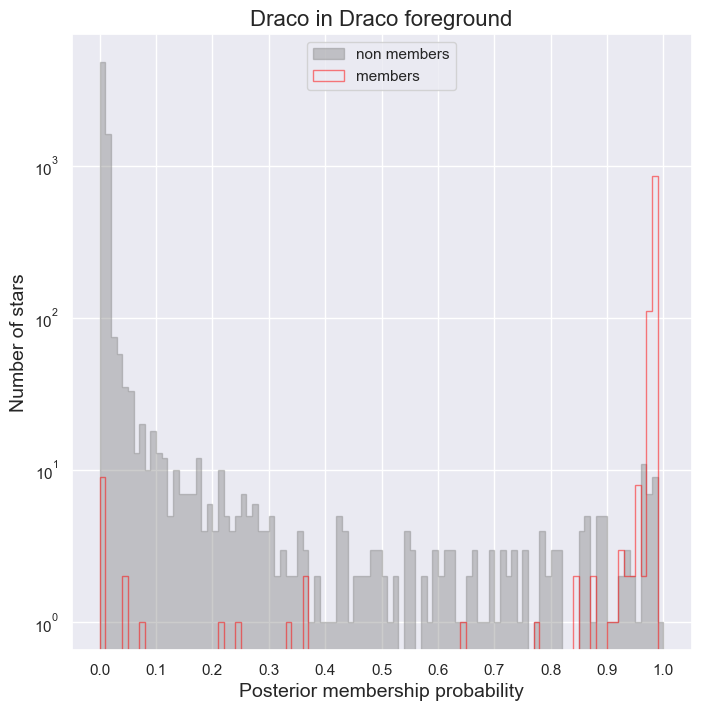

In [75]:
hist = histogram_prob(df, actual_members, nonmembers)

hist.savefig(path+glxName+"In"+bgName+"_UMAp_histogram_Prob.png", dpi=300, bbox_inches='tight')

In [76]:
def confusion_plots(table, members_threshold, nonmembers_threshold, members_indices, plotfigure=True, P='P UMAP'):
    
    # Initialize sets for TP, FP, FN, TN
    Ndata = table.shape[0]


    true_positive = np.where((table['source_id'].values == 42.0) & (table[P].values > members_threshold))[0]
    false_negative = np.where((table['source_id'].values == 42.0) & (table[P].values < nonmembers_threshold))[0]
    false_positive = np.where((table['source_id'].values != 42.0) & (table[P].values > members_threshold))[0]
    true_negative = np.where((table['source_id'].values != 42.0) & (table[P].values < nonmembers_threshold))[0]


    print('actual members: ',len(members_indices))
    print('true positive: ',len(true_positive))
    print('false positive: ',len(false_positive))
    print('')
    print('actual non members: ',Ndata-len(members_indices))
    print('true negative: ',len(true_negative))
    print('false negative: ',len(false_negative))


    # MAKING THE PLOT
    confusion_type = ['TP', 'FP', 'FN', 'TN']

    confusion_dict = {
        'TP': true_positive,
        'FP': false_positive,
        'FN': false_negative,
        'TN': true_negative
    }

    print(len(confusion_dict[confusion_type[0]]))

    if plotfigure:

        fig, ax = plt.subplots(4, 3, figsize=(15, 20))
        fig.suptitle(f'Confusion plots {glxName} in {bgName}: thresholds {nonmembers_threshold} - {members_threshold}; members={len(members_indices)} non members={Ndata-len(members_indices)}', fontsize=18)
        for i in range(4):
            if confusion_type[i] == 'TP' or confusion_type[i] == 'FN':

                ax[i, 0].scatter(table['Xi'], table['Xn'], s=5, alpha=0.2, c='grey')
                ax[i, 0].scatter(table.loc[confusion_dict[confusion_type[i]], ['Xi']], table.loc[confusion_dict[confusion_type[i]], ['Xn']], s=10, c='red',
                                label=f'{confusion_type[i]}: {len(confusion_dict[confusion_type[i]])} - {len(confusion_dict[confusion_type[i]])/len(members_indices)*100:.2f}%')
                ax[i, 0].set_xlabel('Xi [deg]')
                ax[i, 0].set_ylabel('Xn [deg]')
                ax[i, 0].legend(loc='upper left', fontsize=13)

                ax[i, 1].scatter(table['PMra'], table['PMdec'], s=5, alpha=0.2, c='grey')
                ax[i, 1].scatter(table.loc[confusion_dict[confusion_type[i]], ['PMra']], table.loc[confusion_dict[confusion_type[i]], ['PMdec']], s=10, c='red')
                ax[i, 1].set_xlabel('PMra [mas/yr]')
                ax[i, 1].set_ylabel('PMdec [mas/yr]')

                ax[i, 2].scatter(table['BP0-RP0'], table['G0_c'], s=5, alpha=0.2, c='grey')
                ax[i, 2].scatter(table.loc[confusion_dict[confusion_type[i]], ['BP0-RP0']], table.loc[confusion_dict[confusion_type[i]], ['G0_c']], s=10, c='red')
                ax[i, 2].invert_yaxis()
                ax[i, 2].set_xlabel('BP0-RP0')
                ax[i, 2].set_ylabel('G0_c')

            else:

                ax[i, 0].scatter(table['Xi'], table['Xn'], s=5, alpha=0.2, c='grey')
                ax[i, 0].scatter(table.loc[confusion_dict[confusion_type[i]], ['Xi']], table.loc[confusion_dict[confusion_type[i]], ['Xn']], s=10, c='red',
                                label=f'{confusion_type[i]}: {len(confusion_dict[confusion_type[i]])} - {len(confusion_dict[confusion_type[i]])/(Ndata-len(members_indices))*100:.2f}%')
                ax[i, 0].set_xlabel('Xi [deg]')
                ax[i, 0].set_ylabel('Xn [deg]')
                ax[i, 0].legend(loc='upper left', fontsize=13)

                ax[i, 1].scatter(table['PMra'], table['PMdec'], s=5, alpha=0.2, c='grey')
                ax[i, 1].scatter(table.loc[confusion_dict[confusion_type[i]], ['PMra']], table.loc[confusion_dict[confusion_type[i]], ['PMdec']], s=10, c='red')
                ax[i, 1].set_xlabel('PMra [mas/yr]')
                ax[i, 1].set_ylabel('PMdec [mas/yr]')

                ax[i, 2].scatter(table['BP0-RP0'], table['G0_c'], s=5, alpha=0.2, c='grey')
                ax[i, 2].scatter(table.loc[confusion_dict[confusion_type[i]], ['BP0-RP0']], table.loc[confusion_dict[confusion_type[i]], ['G0_c']], s=10, c='red')
                ax[i, 2].invert_yaxis()
                ax[i, 2].set_xlabel('BP0-RP0')
                ax[i, 2].set_ylabel('G0_c')
        
        plt.tight_layout()
        plt.show()        
    
        return fig, true_positive, false_positive, false_negative, true_negative, len(members_indices), Ndata-len(members_indices)
    
    else:
        return true_positive, false_positive, false_negative, true_negative, len(members_indices), Ndata-len(members_indices)

actual members:  1010
true positive:  978
false positive:  29

actual non members:  6965
true negative:  6395
false negative:  9
978


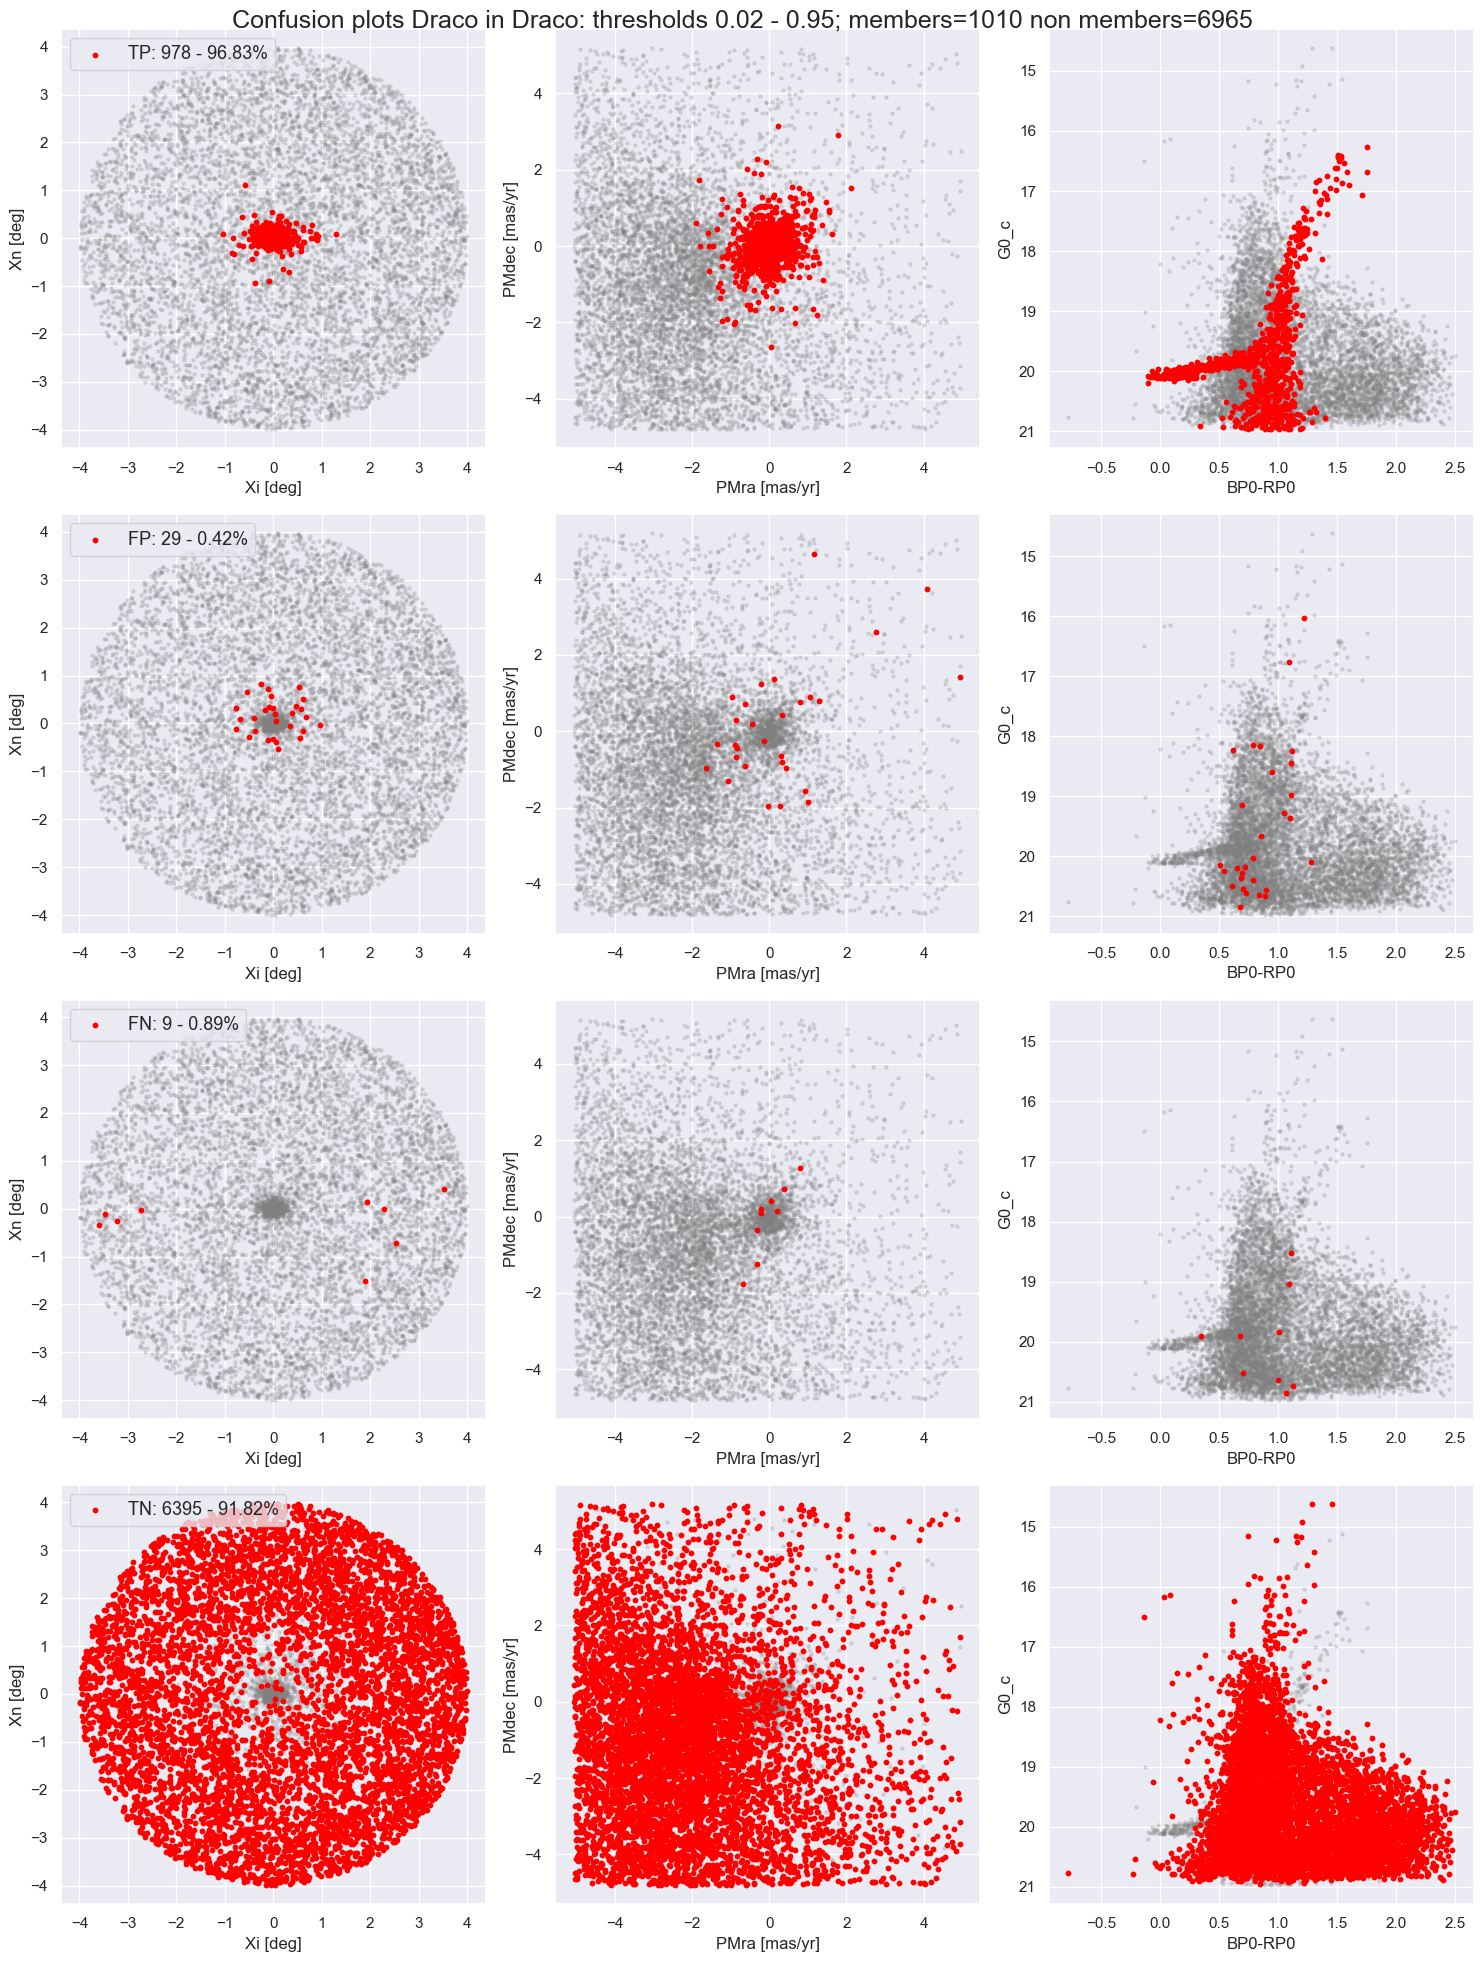

In [77]:
members_threshold = 0.95
nonmembers_threshold = 0.02

df_confusion, TP, FP, FN, TN, members_count, nonmembers_count = confusion_plots(df, members_threshold, nonmembers_threshold, actual_members)

df_confusion.savefig(path+glxName+"In"+bgName+"_UMAP_confusion_plots_002_095.png", dpi=300, bbox_inches='tight')

### creating cvs files

In [78]:
confusion_matrix = pd.DataFrame({
    'Threshold': [f'{nonmembers_threshold} - {members_threshold}'],
    'TP': [len(TP)],
    'TP %': [round(len(TP) / members_count * 100, 2)],
    'FP': [len(FP)],
    'FP %': [round(len(FP) / nonmembers_count * 100, 2)],
    'FN': [len(FN)],
    'FN %': [round(len(FN) / members_count * 100, 2)],
    'TN': [len(TN)],
    'TN %': [round(len(TN) / nonmembers_count * 100, 2)]
})

i = 0

confusion_matrix.head()

,Threshold,TP,TP %,FP,FP %,FN,FN %,TN,TN %
0,0.02 - 0.95,978,96.83,29,0.42,9,0.89,6395,91.82


In [79]:
members_threshold = 0.95
nonmembers_threshold = 0.05

TP, FP, FN, TN, members_count, nonmembers_count = confusion_plots(df, members_threshold, nonmembers_threshold, actual_members, plotfigure=False)

new_raw = [f'{nonmembers_threshold} - {members_threshold}',
    len(TP),
    round(len(TP) / members_count * 100, 2),
    len(FP),
    round(len(FP) / nonmembers_count * 100, 2),
    len(FN),
    round(len(FN) / members_count * 100, 2),
    len(TN),
    round(len(TN) / nonmembers_count * 100, 2)]

i+= 1

confusion_matrix.loc[i] = new_raw

confusion_matrix.head()

actual members:  1010
true positive:  978
false positive:  29

actual non members:  6965
true negative:  6563
false negative:  11
978


,Threshold,TP,TP %,FP,FP %,FN,FN %,TN,TN %
0,0.02 - 0.95,978,96.83,29,0.42,9,0.89,6395,91.82
1,0.05 - 0.95,978,96.83,29,0.42,11,1.09,6563,94.23


In [80]:
members_threshold = 0.95
nonmembers_threshold = 0.1

TP, FP, FN, TN, members_count, nonmembers_count = confusion_plots(df, members_threshold, nonmembers_threshold, actual_members, plotfigure=False)

new_raw = [f'{nonmembers_threshold} - {members_threshold}',
    len(TP),
    round(len(TP) / members_count * 100, 2),
    len(FP),
    round(len(FP) / nonmembers_count * 100, 2),
    len(FN),
    round(len(FN) / members_count * 100, 2),
    len(TN),
    round(len(TN) / nonmembers_count * 100, 2)]

i+= 1

confusion_matrix.loc[i] = new_raw

confusion_matrix.head()

actual members:  1010
true positive:  978
false positive:  29

actual non members:  6965
true negative:  6657
false negative:  12
978


,Threshold,TP,TP %,FP,FP %,FN,FN %,TN,TN %
0,0.02 - 0.95,978,96.83,29,0.42,9,0.89,6395,91.82
1,0.05 - 0.95,978,96.83,29,0.42,11,1.09,6563,94.23
2,0.1 - 0.95,978,96.83,29,0.42,12,1.19,6657,95.58


In [81]:
members_threshold = 0.9
nonmembers_threshold = 0.2

TP, FP, FN, TN, members_count, nonmembers_count = confusion_plots(df, members_threshold, nonmembers_threshold, actual_members, plotfigure=False)

new_raw = [f'{nonmembers_threshold} - {members_threshold}',
    len(TP),
    round(len(TP) / members_count * 100, 2),
    len(FP),
    round(len(FP) / nonmembers_count * 100, 2),
    len(FN),
    round(len(FN) / members_count * 100, 2),
    len(TN),
    round(len(TN) / nonmembers_count * 100, 2)]

i+= 1

confusion_matrix.loc[i] = new_raw

confusion_matrix.head()

actual members:  1010
true positive:  987
false positive:  38

actual non members:  6965
true negative:  6740
false negative:  12
987


,Threshold,TP,TP %,FP,FP %,FN,FN %,TN,TN %
0,0.02 - 0.95,978,96.83,29,0.42,9,0.89,6395,91.82
1,0.05 - 0.95,978,96.83,29,0.42,11,1.09,6563,94.23
2,0.1 - 0.95,978,96.83,29,0.42,12,1.19,6657,95.58
3,0.2 - 0.9,987,97.72,38,0.55,12,1.19,6740,96.77


In [82]:
members_threshold = 0.5
nonmembers_threshold = 0.5

TP, FP, FN, TN, members_count, nonmembers_count = confusion_plots(df, members_threshold, nonmembers_threshold, actual_members, plotfigure=False)

new_raw = [f'{nonmembers_threshold} - {members_threshold}',
    len(TP),
    round(len(TP) / members_count * 100, 2),
    len(FP),
    round(len(FP) / nonmembers_count * 100, 2),
    len(FN),
    round(len(FN) / members_count * 100, 2),
    len(TN),
    round(len(TN) / nonmembers_count * 100, 2)]

i+= 1

confusion_matrix.loc[i] = new_raw

confusion_matrix.head()

actual members:  1010
true positive:  993
false positive:  121

actual non members:  6965
true negative:  6843
false negative:  17
993


,Threshold,TP,TP %,FP,FP %,FN,FN %,TN,TN %
0,0.02 - 0.95,978,96.83,29,0.42,9,0.89,6395,91.82
1,0.05 - 0.95,978,96.83,29,0.42,11,1.09,6563,94.23
2,0.1 - 0.95,978,96.83,29,0.42,12,1.19,6657,95.58
3,0.2 - 0.9,987,97.72,38,0.55,12,1.19,6740,96.77
4,0.5 - 0.5,993,98.32,121,1.74,17,1.68,6843,98.25


In [83]:
## single umap cnfusion
P = "members_umap"

true_positive_S = np.where((df['source_id'].values == 42.0) & (df[P].values == 1.0))[0]
false_negative_S = np.where((df['source_id'].values == 42.0) & (df[P].values == 0.0))[0]
false_positive_S= np.where((df['source_id'].values != 42.0) & (df[P].values == 1.0))[0]
true_negative_S = np.where((df['source_id'].values != 42.0) & (df[P].values == 0.0))[0]

print('true positive_S: ',len(true_positive_S))
print('false positive_S: ',len(false_positive_S))
print('true negative_S: ',len(true_negative_S))
print('false negative_S: ',len(false_negative_S))

true positive_S:  998
false positive_S:  122
true negative_S:  6843
false negative_S:  12


In [84]:
new_raw = [f'single UMAP',
    len(true_positive_S),
    round(len(true_positive_S) / members_count * 100, 2),
    len(false_positive_S),
    round(len(false_positive_S) / nonmembers_count * 100, 2),
    len(false_negative_S),
    round(len(false_negative_S) / members_count * 100, 2),
    len(true_negative_S),
    round(len(true_negative_S) / nonmembers_count * 100, 2)]

i+= 1

confusion_matrix.loc[i] = new_raw

confusion_matrix.head(10)

,Threshold,TP,TP %,FP,FP %,FN,FN %,TN,TN %
0,0.02 - 0.95,978,96.83,29,0.42,9,0.89,6395,91.82
1,0.05 - 0.95,978,96.83,29,0.42,11,1.09,6563,94.23
2,0.1 - 0.95,978,96.83,29,0.42,12,1.19,6657,95.58
3,0.2 - 0.9,987,97.72,38,0.55,12,1.19,6740,96.77
4,0.5 - 0.5,993,98.32,121,1.74,17,1.68,6843,98.25
5,single UMAP,998,98.81,122,1.75,12,1.19,6843,98.25


In [85]:
confusion_matrix.to_csv(path+glxName+"In"+bgName+"_UMAP_confusion_matrix.csv", index=False)

## Confusion matrix Salvatore per confronto

In [86]:
from astropy.table import Table

file = "../DATA/out_test_"+glxName+"In"+bgName+"_mock_8deg_25052025_eDR3.fits"

df_sal = Table.read(file, format='fits').to_pandas()

print(df_sal.shape)

(182500, 35)


In [87]:
print(df_sal.columns)

Index(['source_id', 'ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'pmra', 'pmdec', 'phot_g_n_obs', 'phot_bp_n_obs',
       'phot_rp_n_obs', 'astrometric_matched_transits',
       'visibility_periods_used', 'ipd_gof_harmonic_amplitude',
       'phot_g_mean_mag_err', 'phot_bp_mean_mag_err', 'phot_rp_mean_mag_err',
       'parallax_error', 'pmra_error', 'pmdec_error', 'parallax',
       'ipd_frac_multi_peak', 'ruwe', 'bp_rp', 'phot_bp_rp_excess_factor',
       'pmra_pmdec_corr', 'astrometric_n_good_obs_al',
       'astrometric_params_solved', 'G0_c', 'BP0', 'RP0', 'Xi', 'Xn', 'Rad',
       'P'],
      dtype='object')


In [88]:
df_sal_UMAP = df_sal[df_sal['source_id'].isin(df['source_id'])].copy()
print(df_sal_UMAP.shape)
print(df.shape)

(7975, 35)
(7975, 19)


In [89]:
members_threshold = 0.95
nonmembers_threshold = 0.02

TP, FP, FN, TN, members_count, nonmembers_count = confusion_plots(df_sal_UMAP, members_threshold, nonmembers_threshold, actual_members, plotfigure=False, P='P')

confusion_matrix_sal_UMAP = pd.DataFrame({
    'Threshold': [f'{nonmembers_threshold} - {members_threshold}'],
    'TP': [len(TP)],
    'TP %': [round(len(TP) / members_count * 100, 2)],
    'FP': [len(FP)],
    'FP %': [round(len(FP) / nonmembers_count * 100, 2)],
    'FN': [len(FN)],
    'FN %': [round(len(FN) / members_count * 100, 2)],
    'TN': [len(TN)],
    'TN %': [round(len(TN) / nonmembers_count * 100, 2)]
})

i = 0

confusion_matrix_sal_UMAP.head()

actual members:  1010
true positive:  894
false positive:  1

actual non members:  6965
true negative:  6891
false negative:  6
894


,Threshold,TP,TP %,FP,FP %,FN,FN %,TN,TN %
0,0.02 - 0.95,894,88.51,1,0.01,6,0.59,6891,98.94


In [90]:
members_threshold = 0.95
nonmembers_threshold = 0.05

TP, FP, FN, TN, members_count, nonmembers_count = confusion_plots(df_sal_UMAP, members_threshold, nonmembers_threshold, actual_members, plotfigure=False, P='P')

new_raw = [f'{nonmembers_threshold} - {members_threshold}',
    len(TP),
    round(len(TP) / members_count * 100, 2),
    len(FP),
    round(len(FP) / nonmembers_count * 100, 2),
    len(FN),
    round(len(FN) / members_count * 100, 2),
    len(TN),
    round(len(TN) / nonmembers_count * 100, 2)]

i+= 1

confusion_matrix_sal_UMAP.loc[i] = new_raw

confusion_matrix_sal_UMAP.head()

actual members:  1010
true positive:  894
false positive:  1

actual non members:  6965
true negative:  6919
false negative:  13
894


,Threshold,TP,TP %,FP,FP %,FN,FN %,TN,TN %
0,0.02 - 0.95,894,88.51,1,0.01,6,0.59,6891,98.94
1,0.05 - 0.95,894,88.51,1,0.01,13,1.29,6919,99.34


In [91]:
members_threshold = 0.95
nonmembers_threshold = 0.1

TP, FP, FN, TN, members_count, nonmembers_count = confusion_plots(df_sal_UMAP, members_threshold, nonmembers_threshold, actual_members, plotfigure=False, P='P')

new_raw = [f'{nonmembers_threshold} - {members_threshold}',
    len(TP),
    round(len(TP) / members_count * 100, 2),
    len(FP),
    round(len(FP) / nonmembers_count * 100, 2),
    len(FN),
    round(len(FN) / members_count * 100, 2),
    len(TN),
    round(len(TN) / nonmembers_count * 100, 2)]

i+= 1

confusion_matrix_sal_UMAP.loc[i] = new_raw

confusion_matrix_sal_UMAP.head()

actual members:  1010
true positive:  894
false positive:  1

actual non members:  6965
true negative:  6931
false negative:  20
894


,Threshold,TP,TP %,FP,FP %,FN,FN %,TN,TN %
0,0.02 - 0.95,894,88.51,1,0.01,6,0.59,6891,98.94
1,0.05 - 0.95,894,88.51,1,0.01,13,1.29,6919,99.34
2,0.1 - 0.95,894,88.51,1,0.01,20,1.98,6931,99.51


In [92]:
members_threshold = 0.9
nonmembers_threshold = 0.2

TP, FP, FN, TN, members_count, nonmembers_count = confusion_plots(df_sal_UMAP, members_threshold, nonmembers_threshold, actual_members, plotfigure=False, P='P')

new_raw = [f'{nonmembers_threshold} - {members_threshold}',
    len(TP),
    round(len(TP) / members_count * 100, 2),
    len(FP),
    round(len(FP) / nonmembers_count * 100, 2),
    len(FN),
    round(len(FN) / members_count * 100, 2),
    len(TN),
    round(len(TN) / nonmembers_count * 100, 2)]

i+= 1

confusion_matrix_sal_UMAP.loc[i] = new_raw

confusion_matrix_sal_UMAP.head()

actual members:  1010
true positive:  931
false positive:  3

actual non members:  6965
true negative:  6943
false negative:  25
931


,Threshold,TP,TP %,FP,FP %,FN,FN %,TN,TN %
0,0.02 - 0.95,894,88.51,1,0.01,6,0.59,6891,98.94
1,0.05 - 0.95,894,88.51,1,0.01,13,1.29,6919,99.34
2,0.1 - 0.95,894,88.51,1,0.01,20,1.98,6931,99.51
3,0.2 - 0.9,931,92.18,3,0.04,25,2.48,6943,99.68


In [93]:
members_threshold = 0.5
nonmembers_threshold = 0.5

TP, FP, FN, TN, members_count, nonmembers_count = confusion_plots(df_sal_UMAP, members_threshold, nonmembers_threshold, actual_members, plotfigure=False, P='P')

new_raw = [f'{nonmembers_threshold} - {members_threshold}',
    len(TP),
    round(len(TP) / members_count * 100, 2),
    len(FP),
    round(len(FP) / nonmembers_count * 100, 2),
    len(FN),
    round(len(FN) / members_count * 100, 2),
    len(TN),
    round(len(TN) / nonmembers_count * 100, 2)]

i+= 1

confusion_matrix_sal_UMAP.loc[i] = new_raw

confusion_matrix_sal_UMAP.head()

actual members:  1010
true positive:  979
false positive:  10

actual non members:  6965
true negative:  6954
false negative:  31
979


,Threshold,TP,TP %,FP,FP %,FN,FN %,TN,TN %
0,0.02 - 0.95,894,88.51,1,0.01,6,0.59,6891,98.94
1,0.05 - 0.95,894,88.51,1,0.01,13,1.29,6919,99.34
2,0.1 - 0.95,894,88.51,1,0.01,20,1.98,6931,99.51
3,0.2 - 0.9,931,92.18,3,0.04,25,2.48,6943,99.68
4,0.5 - 0.5,979,96.93,10,0.14,31,3.07,6954,99.84


In [94]:
confusion_matrix_sal_UMAP.to_csv(path+glxName+"In"+bgName+"_UMAP_confusion_matrix_sal_UMAP.csv", index=False)